# Random Forest Classifier implementation
Created for the bachelor thesis of Jakub Dvorak | jakub.dvorak@natur.cuni.cz<br>
Department of Applied Geoinformatics and Cartography, Faculty of Science, Charles University

Adapted from EduServ18 (2020): 3D Sensing, Scene Reconstruction and Semantic Interpretation<br>
The original code was created by Martin Weinmann, Franz Rottensteiner and Dennis Wittich

__imports__ and __settings__:

In [1]:
# IMPORTS
import os
import numpy as np
from time import time as time
import imageio
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV as GridSearch
from sklearn.model_selection import RandomizedSearchCV as RandomizedSearch

# GLOBAL SETTINGS
PlotSize = 8                                     # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize]  
CMAP = matplotlib.colors.ListedColormap(['black', 'white', 'orange'])               # Color mapping 
np.set_printoptions(precision=2, suppress=True)  # Array print precision

# CLASS AND FEATURE DESCRIPTION
class_names = ['BACKGRD','PINUS','PICEA']
feature_names = ['NIR','RED','GREEN','NDVI']
num_classes = len(class_names); num_features = len(feature_names)

# PATHS TO TRAIN/TEST DATA
data_path = '../data/split_05__05_512/'
training_set_path = data_path + 'train/'         # Relative path to training patch root folder
test_set_path =     data_path + 'test/'         # Relative path to test patch root folder

num_of_training_tiles = len(os.listdir(training_set_path + 'CIR/'))
num_of_test_tiles = len(os.listdir(test_set_path + 'CIR/'))

# USE CIR OR RGB DATA
use_cir = True
use_rgb = True
patch_size = 512

## Data import and handling
Following function reads input data and creates numpy arrays out of it

In [2]:
def read_patch(root_folder, cir, rgb):
    ##########################################################
    # READ IMAGES as FLOAT
    if cir:
        cir_file_list = os.listdir(root_folder + 'CIR/')
        cir_list = []
        
        for file in cir_file_list:
            cir_patch = imageio.imread(root_folder + 'CIR/' + file).astype(np.float32)
            cir_patch = cir_patch * 1/255
            
            h, w = cir_patch.shape[:2]
            num_samples = h*w
            cir_list.append(cir_patch[:,:,:].reshape((num_samples, 3)))
            del cir_patch

        cir_features = np.concatenate(cir_list, axis=0)
    
    if rgb:
        rgb_file_list = os.listdir(root_folder + 'RGB/')
        rgb_list = []
        
        for file in rgb_file_list:
            rgb_patch = imageio.imread(root_folder + 'RGB/' + file).astype(np.float32)
            rgb_patch = rgb_patch * 1/255
            
            h, w = rgb_patch.shape[:2]
            num_samples = h*w
            rgb_list.append(rgb_patch[:,:,:].reshape((num_samples, 3)))
            del rgb_patch
        
        rgb_features = np.concatenate(rgb_list, axis=0)


    if cir and rgb:
        features = np.concatenate([cir_features, rgb_features], axis=1)
    elif cir:
        features = cir_features
    elif rgb:
        features = rgb_features
    else:
        print('No valid data input.')


    gt_file_list = os.listdir(root_folder + 'GT/')
    gt_list = []

    for file in gt_file_list:
        gt_patch = imageio.imread(root_folder + 'GT/' + file).astype(np.float32)
 
        h, w = gt_patch.shape[:2]
        num_samples = h*w
    
        gt_list.append(gt_patch[:,:].reshape((num_samples)))
        del gt_patch

    ground_truth = np.concatenate(gt_list, axis=0)

    ########################################################## 
    return features, ground_truth

In [3]:
a = time()
X, y = read_patch(training_set_path, use_cir, use_rgb)
b = time()
X_t, y_t = read_patch(test_set_path, use_cir, use_rgb)
c = time()

print('Training set loaded in ' + str(b-a) + 's')
print('Testing set loaded in ' + str(c-b) + 's')
print(X.shape)
print(y.shape)
print(X.max())
print(X.min())

Training set loaded in 0.8337764739990234s
Testing set loaded in 0.8038430213928223s
(5242880, 6)
(5242880,)
1.0
0.007843138


## Visualisation function
The following function visualises IRRG, ground truth and predicted labels

In [4]:
def plot_rgb_cir_gt_pred(tile_index, data, gt, pred, num_of_tiles, cir, rgb, size):
    # Function to plot prediction vs ground truth
    
    # Split the datasets into tiles
    data_list = np.split(data, num_of_tiles)
    gt_list =   np.split(gt,   num_of_tiles)
    pred_list = np.split(pred, num_of_tiles)
    
    # Select tile by tile_index and reshape to original dimensions
    data = data_list[tile_index].reshape((size,size,data.shape[1]))
    gt   = gt_list[tile_index].reshape((size,size))
    pred = pred_list[tile_index].reshape((size,size))
    
    # Plotting
    plt.figure(facecolor='white')
    
    if cir and rgb:
        plt.subplot(1, 4, 1)
        plt.imshow(data[:,:,:3])
        plt.title('NIR Red Green composite')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(data[:,:,-3:])
        plt.title('Red Green Blue composite')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(gt, CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')
    
    elif cir or rgb:
        plt.subplot(1, 3, 1)
        plt.imshow(data)
        if cir:
            plt.title('NIR Red Green composite')
        else:
            plt.title('Red Green Blue composite')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt, CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')

In [ ]:
plot_rgb_cir_gt_pred(3, X, y, y, num_of_training_tiles, use_cir, use_rgb, patch_size)

## Accuracy metrics
The following function returns accuracy metrics, namely overall accuracy, precision, recall and f1 score

In [5]:
def compute_quality_metrics(Y, y, C):
    # Copy the code from the last lab here
    ##########################################################
    M = np.equal(Y,y).astype(np.int)
    TP = np.array([np.sum( M * (Y==i).astype(np.int)) for i in range(C)])
    FP = np.array([np.sum( (1-M) * (Y==i)) for i in range(C)])
    FN = np.array([np.sum( (1-M) * (y==i)) for i in range(C)])

    precisions = TP/(TP+FP)
    recalls = TP/(TP+FN)
    f1_scores = 2 * precisions * recalls / (precisions + recalls)
    overall_accuracy = np.sum(Y==y) / len(y)
    mean_f1_score = np.mean(f1_scores)
    return precisions, recalls, f1_scores, overall_accuracy, mean_f1_score, TP, FP, FN
    ##########################################################

## Classifier #1
using unadjusted data

In [ ]:
# The fixed parameters are hold constant
fixed_parameters = {
    'n_estimators' : 10,        # Set number of trees to one
    'max_features' : 'sqrt',   # Number of features considered per node: 'square rule'
    'criterion' : 'entropy'    # Splitting criterion: 'information gain'
}

# The tuned parameters are optimized during the grid search.
# Instead of a fixed value, we store a range of values for each variable
tunable_parameters = { 
    'max_depth': range(8, 11),        # Maximum depth of the tree
    'min_samples_split': range(5, 9)  # Min. number of samples in a node to continue splitting
}

# Create an instance of the model that is to be optimized
model = RandomForestClassifier(**fixed_parameters)

# Create the optimizer and run the optimization
opt = GridSearch(model, tunable_parameters, cv = 3, scoring="accuracy", refit=False, verbose=1, n_jobs=-1)
opt.fit(X,y)

# Save and print optimal parameters
opt_parameters = opt.best_params_
print("Best found parameters:", opt_parameters)

In [ ]:
fixed_parameters = {
    'n_estimators' : 500,        # Set number of trees
    'max_features' : 'sqrt',   # Number of features considered per node: 'square rule'
    'criterion' : 'entropy'    # Splitting criterion: 'information gain'
}

# Generate the DT classifier
dt = RandomForestClassifier(**fixed_parameters, max_depth=8, min_samples_split=7, n_jobs=-1)#**opt_parameters)

# Train the classifier
a = time()
dt.fit(X, y)
b = time()

# Measure overall accuracy
# print('Training set overall accuracy: {0:.2%}'.format(dt.score(X, y)))
# print('Test set overall accuracy:     {0:.2%}'.format(dt.score(X_t, y_t)))
print('Training finished in ' + str(b-a) + 's')

In [ ]:
a = time()
Y_t = dt.predict(X_t)
b = time()

print('Inferrence finished in ' + str(b-a) + 's')

In [ ]:
precisions, recalls, f1_scores, overall_accuracy, mean_f1_score,TrueP, FalseP, FalseN = compute_quality_metrics(Y_t, y_t, 3)
print('precisions [%]:      ', precisions*100)
print('recalls    [%]:      ', recalls*100)
print('f1_scores  [%]:      ', f1_scores*100)
print('')
print('overall accuracy: {:.2%}'.format(overall_accuracy))
print('mean f1 score:    {:.2%}'.format(mean_f1_score))
print('True Positive:' + str(TrueP) + '\nFalse Positive:' + str(FalseP) + '\nFalse Negative:' + str(FalseN))

In [ ]:
plot_irrg_gt_pred(3, X_t, y_t, Y_t, num_of_test_tiles)

## Classifier #2
using uniformly distributed training data

In [ ]:
def get_random_training_subset(X, y, N_s):
    ##########################################################
    Xy = np.hstack((X,y.reshape((-1, 1))))
    np.random.shuffle(Xy)
    
    X_s = Xy[:N_s, :-1]
    y_s = Xy[:N_s, -1]        
    ##########################################################
    return X_s, y_s

In [6]:
def get_uniform_training_subset(X, y, N_s, num_classes=3):
    ##########################################################
    N, F = X.shape
    counts = np.zeros(num_classes)
    num_drawn = 0
    X_s = np.zeros((N_s, F), dtype=np.float32)
    y_s = np.zeros((N_s,), dtype=np.float32)
    
    while(num_drawn < N_s):
        i = np.random.randint(N)
        yi = y[i]
        if yi == np.argmin(counts):
            counts[int(yi)] += 1
            X_s[num_drawn] = X[i]
            y_s[num_drawn] = yi
            num_drawn += 1
    ##########################################################
    return X_s, y_s

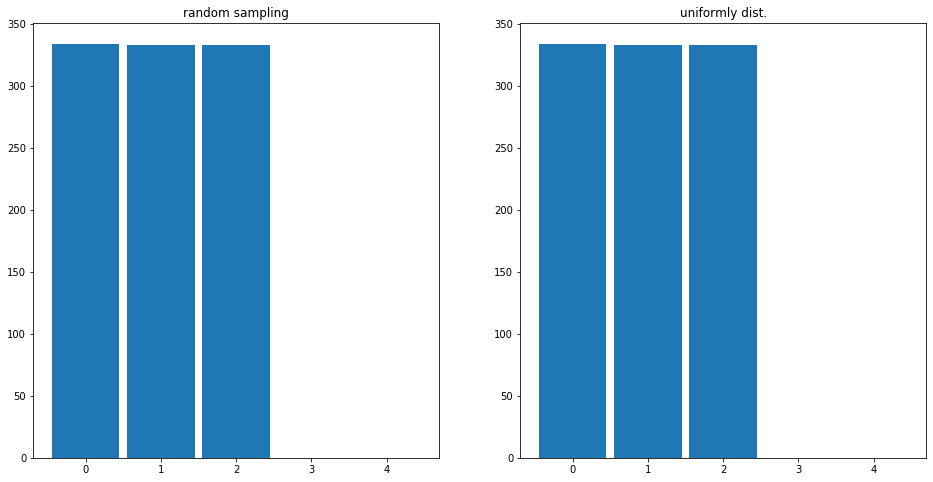

In [7]:
N_s = 1000
#X_rs, y_rs = get_random_training_subset(X, y, N_s)
X_es, y_es = get_uniform_training_subset(X, y, N_s)

plt.subplot(1,2,1)
plt.hist(y_es,bins=range(6), rwidth=0.9, align='left') #rewrite to y_rs
plt.title('random sampling')
plt.subplot(1,2,2)
plt.hist(y_es,bins=range(6), rwidth=0.9, align='left')
plt.title('uniformly dist.')
plt.show()

In [8]:
fixed_parameters = {
    'n_estimators' : 10,        # Set number of trees to one
    'max_features' : 'sqrt',   # Number of features considered per node: 'square rule'
    'criterion' : 'entropy'    # Splitting criterion: 'information gain'
}

# Generate the RF classifier
dt = RandomForestClassifier(**fixed_parameters, max_depth=8, min_samples_split=7, n_jobs=-1)#**opt_parameters)

# Train the classifier
a = time()
dt.fit(X_es, y_es)
b = time()

# Measure overall accuracy
# print('Training set overall accuracy: {0:.2%}'.format(dt.score(X_es, y_es)))
c = time()
# print('Test set overall accuracy:     {0:.2%}'.format(dt.score(X_t, y_t)))
d = time()
print('')
print('Training finished in ' + str(b-a) + 's')
print('Measuring training set score finished in ' + str(c-b) + 's')
print('Measuring test set score finished in ' + str(d-c) + 's')


Training finished in 0.12691307067871094s
Measuring training set score finished in 0.0s
Measuring test set score finished in 0.0s


In [9]:
a = time()
Y_t = dt.predict(X_t)
b = time()

print('Inferrence finished in ' + str(b-a) + 's')

Inferrence finished in 2.7936909198760986s


In [10]:
precisions, recalls, f1_scores, overall_accuracy, mean_f1_score,TrueP, FalseP, FalseN = compute_quality_metrics(Y_t, y_t, 3)
print('precisions [%]:      ', precisions*100)
print('recalls    [%]:      ', recalls*100)
print('f1_scores  [%]:      ', f1_scores*100)
print('')
print('overall accuracy: {:.2%}'.format(overall_accuracy))
print('mean f1 score:    {:.2%}'.format(mean_f1_score))
print('True Positive:' + str(TrueP) + '\nFalse Positive:' + str(FalseP) + '\nFalse Negative:' + str(FalseN))

precisions [%]:       [78.46 62.48 11.79]
recalls    [%]:       [45.3  59.21 59.22]
f1_scores  [%]:       [57.44 60.8  19.67]

overall accuracy: 52.25%
mean f1 score:    45.97%
True Positive:[1188709 1369598  181112]
False Positive:[ 326324  822288 1354849]
False Negative:[1435313  943413  124735]


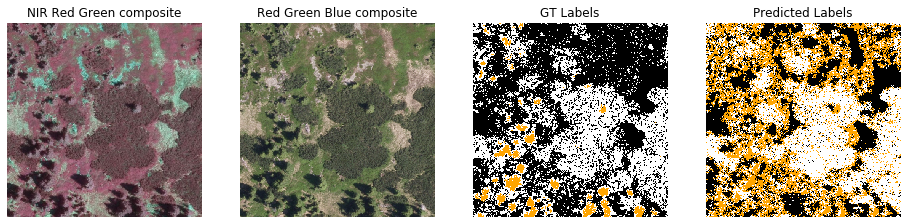

In [11]:
plot_rgb_cir_gt_pred(8, X_t, y_t, Y_t, num_of_test_tiles, use_cir, use_rgb, patch_size)

In [13]:
a = time()
np.savetxt(data_path + 'results/rf.csv', Y_t, fmt='%d')
b = time()

print('Results saved in ' + str(b-a) + 's')